# 项目架构

project_root/  
│  
├── data/  
│   ├── test_data/              # 测试数据  
│   ├── train_data/        # 训练数据  
│   └── datasets.py       # 数据集类的定义以及数据集加载和预处理的相关函数   
│  
├── models/               
│   └── network.py        # 网络结构的定义  
│  
├── *notebook             # 具体任务处理文件  
│  
├── saved_models/         # 存放保存的模型  
│  
├── README.md             # 项目说明文档  
│  
└── requirements.txt      # Python依赖包清单  

In [1]:
import os
os.makedirs('data', exist_ok=True)
os.makedirs('models', exist_ok=True)

# 数据观察

shape= (321, 80)


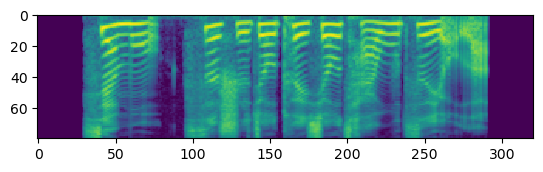

shape= (374, 80)


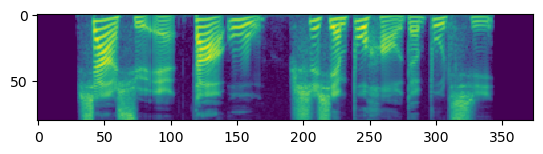

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
arr=np.load("data/train_data/language_0/F001_010.npy")
print('shape=',arr.shape)
plt.imshow(arr.T, cmap='viridis', interpolation='nearest')
plt.show()
arr2=np.load("data/test_data/test_0006.npy")
print('shape=',arr2.shape)
plt.imshow(arr2.T, cmap='viridis', interpolation='nearest')
plt.show()

# 构造数据集类

In [4]:
# %%writefile data/datasets.py

import os
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

# 定义一个MelFrequencyDataset数据集类
class MelFrequencyDataset(Dataset):
    def __init__(self, data_dir, max_seq_length=300):
        self.data = []
        self.labels = []
        self.max_seq_length = max_seq_length
        label_folders = os.listdir(data_dir)
        for label_folder in label_folders:
            label = 0 if label_folder=='language_0' else 1  # 文件夹名字即为标签
            record_path = os.path.join(data_dir, label_folder)
            for file in os.listdir(record_path):
                file_path = os.path.join(record_path, file)
                self.data.append(file_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path = self.data[idx]
        label = self.labels[idx]
        # 加载梅尔频率数据
        mel_data = np.load(file_path)  # 假设是.npy格式的文件
        # 对数据进行填充或截断
        if mel_data.shape[0] < self.max_seq_length:
            # 填充到最大长度
            pad_length = self.max_seq_length - mel_data.shape[0]
            mel_data = np.pad(mel_data, ((0, pad_length), (0, 0)), mode='constant', constant_values=0)
        elif mel_data.shape[0] > self.max_seq_length:
            # 截断到最大长度
            mel_data = mel_data[:self.max_seq_length, :]
        # 将梅尔频率特征转换为PyTorch张量并返回
        return torch.tensor(mel_data), torch.tensor(label)

In [5]:
##### 检查数据集类定义是否有效 #####
dataset = MelFrequencyDataset(data_dir='data/train_data')
# 查看前几个样本
for i in range(5):
    sample, label = dataset[i]
    print(sample.shape, label)

torch.Size([300, 80]) tensor(1)
torch.Size([300, 80]) tensor(1)
torch.Size([300, 80]) tensor(1)
torch.Size([300, 80]) tensor(1)
torch.Size([300, 80]) tensor(1)


# 构造模型类

In [6]:
# %%writefile models/network.py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import math

class MelCNN(nn.Module):
    def __init__(self, input_size, num_classes=2):
        super(MelCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        # 根据传入的input_size动态调整全连接层的输入尺寸
        self.fc_input_features = 64 * (input_size[0] // 4) * (input_size[1] // 4)
        self.fc1 = nn.Linear(self.fc_input_features, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # [batch,w,h] -> [batch,channel=1,w,h]
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # 使用nn.Flatten()层展平
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class MelTransformer(nn.Module):
    def __init__(self, input_size=80, hidden_size=128, num_layers=10, num_classes=2):
        super(MelTransformer, self).__init__()
        encoder_layers = TransformerEncoderLayer(d_model=input_size, nhead=4, dim_feedforward=hidden_size, dropout=0.1)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers)
        self.fc = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = x.permute(1, 0, 2)  # 将输入变换为 (seq_len, batch, input_size) 的格式
        output = self.transformer_encoder(x)
        output = output.permute(1, 0, 2)  # 变换回原始的维度顺序
        output = self.fc(output[:, -1, :])  # 取Transformer最后一个时间步的输出作为模型的输出
        return output




In [7]:
##### 验证模型类定义是否有效 ##### 
dataset = MelFrequencyDataset(data_dir='data/train_data',max_seq_length=30)
# 检查CUDA是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 创建数据加载器
train_loader = DataLoader(dataset, batch_size=128, shuffle=True)
# 实例化神经网络模型
# model = MelTransformer([30,80],2).to(device)
model = MelCNN(dataset[0][0].shape,2).to(device)
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# 训练神经网络
model.train()
for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)  # 将输入数据和标签移动到设备上
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    print("loss:",loss.item())
    # 计算准确率
    _, predicted = torch.max(outputs, 1)
    correct = (predicted.cpu() == labels.cpu()).sum().item()
    print("acc:",correct/len(inputs))

loss: 0.7260556817054749
acc: 0.484375
loss: 13.328558921813965
acc: 0.5234375
loss: 4.845221042633057
acc: 0.5234375
loss: 0.6959179639816284
acc: 0.4921875
loss: 0.6938291788101196
acc: 0.5
loss: 0.6938940286636353
acc: 0.484375
loss: 0.6908929944038391
acc: 0.578125
loss: 0.7142459750175476
acc: 0.484375
loss: 0.6979897022247314
acc: 0.484375
loss: 0.6884921193122864
acc: 0.5625
loss: 0.7009570002555847
acc: 0.5
loss: 0.7195457220077515
acc: 0.4296875
loss: 0.710684061050415
acc: 0.4375
loss: 0.6928614377975464
acc: 0.515625
loss: 0.6928979754447937
acc: 0.4921875
loss: 0.6961577534675598
acc: 0.4296875
loss: 0.6932543516159058
acc: 0.4765625
loss: 0.6940033435821533
acc: 0.46875
loss: 0.6930736899375916
acc: 0.5078125
loss: 0.6950061321258545
acc: 0.4375
loss: 0.6931340098381042
acc: 0.5
loss: 0.6931349635124207
acc: 0.734375
loss: 0.6913373470306396
acc: 0.5859375
loss: 0.6955278515815735
acc: 0.4609375
loss: 0.6907036304473877
acc: 0.546875
loss: 0.6975089907646179
acc: 0.453125


# 训练模型

In [8]:
# 实例化数据集
dataset = MelFrequencyDataset(data_dir='data/train_data',max_seq_length=30)


# 划分数据集为训练集和验证集
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [9]:
# 检查CUDA是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 实例化神经网络模型
# model = MelTransformer().to(device)
model = MelCNN(dataset[0][0].shape,2).to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# 注册一个钩子来监测梯度
def gradient_monitoring_hook(module, input_grad, output_grad):
    print('梯度的均值:', input_grad[0].mean().item())
    print('梯度的标准差:', input_grad[0].std().item())

def eval(eval_dataset,model):
    model.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, labels in eval_dataset:
            inputs, labels = inputs.to(device), labels.to(device)  # 将输入数据和标签移动到设备上
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = total_correct / total_samples
    print("Validation Accuracy:", accuracy)

In [38]:
# 训练神经网络
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0  # 用于累积每个epoch的损失
    epoch_correct = 0  # 用于累积每个epoch的正确预测数
    epoch_total = 0  # 用于累积每个epoch的样本总数
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # 将输入数据和标签移动到设备上
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * inputs.size(0)  # 累积损失
        _, predicted = torch.max(outputs, 1)
        epoch_correct += (predicted == labels).sum().item()  # 累积正确预测数
        epoch_total += labels.size(0)  # 累积样本总数
    # 计算每个epoch的平均损失和准确率
    epoch_loss = epoch_loss / len(train_loader.dataset)
    epoch_acc = epoch_correct / epoch_total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')

Epoch [1/10], Loss: 0.1314, Acc: 0.9494
Epoch [2/10], Loss: 0.1308, Acc: 0.9456
Epoch [3/10], Loss: 0.1319, Acc: 0.9475
Epoch [4/10], Loss: 0.1296, Acc: 0.9494
Epoch [5/10], Loss: 0.1266, Acc: 0.9491
Epoch [6/10], Loss: 0.1306, Acc: 0.9472
Epoch [7/10], Loss: 0.1235, Acc: 0.9525
Epoch [8/10], Loss: 0.1264, Acc: 0.9491
Epoch [9/10], Loss: 0.1288, Acc: 0.9469
Epoch [10/10], Loss: 0.1263, Acc: 0.9506


# 在验证集上测试

In [39]:
model.eval()
total_correct = 0
total_samples = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # 将输入数据和标签移动到设备上
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

accuracy = total_correct / total_samples
print("Validation Accuracy:", accuracy)

Validation Accuracy: 0.93


# 保存模型

In [135]:
# 保存模型
torch.save(model.state_dict(), 'saved_models/'+'model_cnn_v2.pth')